# SpectralDefocusCam Iterative Reconstruction Demo

In [1]:
import sys, os, numpy as np
sys.path.insert(0, "../")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import matplotlib.pyplot as plt
import utils.helper_functions as helper
import dataset.precomp_dataset as ds
import train
import numpy

# Change this to GPU or CPU depending on your machine 
device = "cuda:1"

%load_ext autoreload
%autoreload 2

### View calibration data and image

In [4]:
psf_path, exposures = "../data/calibration_data/psfs_ONAXIS_telecent25um", [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
calib_mat_path = "../data/calibration_data/calibration_matrix_450-810_30chan_stride12_avg12.mat"

# TODO: change this to your path
sample_data_path = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data_preprocessed/sample_data_preprocessed_lsi_02_07"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1130, 2080]
crop_size = [768, 768]
patch_size = [256, 256]
ksizes = [7, 21, 45, 55, 65]
num_ims = len(exposures)
threshold = 0.55

stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements
bluridx_offset = 0 # offset of "most in focus" psf

config = {
    "device": device,
    "mask_dir": calib_mat_path,
    "psf_dir": psf_path,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "idx_offset": bluridx_offset,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size,
            "exposures": exposures[bluridx_offset:stack_depth*blurstride:blurstride],
            "w_init": w_init,
            "threshold": threshold
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": True,
            "adjoint": False,
            "spectral_pad": False,
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 600,
        "prox_method": 'tv',
        "tv_lambda": 1.301,
        "tv_lambdaw": 0.66,
        "tv_lambdax": 0.1,
        "print_every": 100
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

model = train.get_model(config, device=device) # full model, runs through forward & backwards

forward_model = model.model1 # forward model (simulation measurement)
recon_model = model.model2 # recon model (reconstruction simulation measurement)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 50.90it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]


In [5]:
# Getting data
_, _, test_loader = ds.get_data_precomputed(
    config["batch_size"], [0.7,0.15,0.15], sample_data_path, shuffle=True
)

for i, test_img in enumerate(test_loader):
    test_img = helper.value_norm(test_img["image"])
    sim_meas_stack = forward_model(test_img[None, ...].to(device)).squeeze()
    break

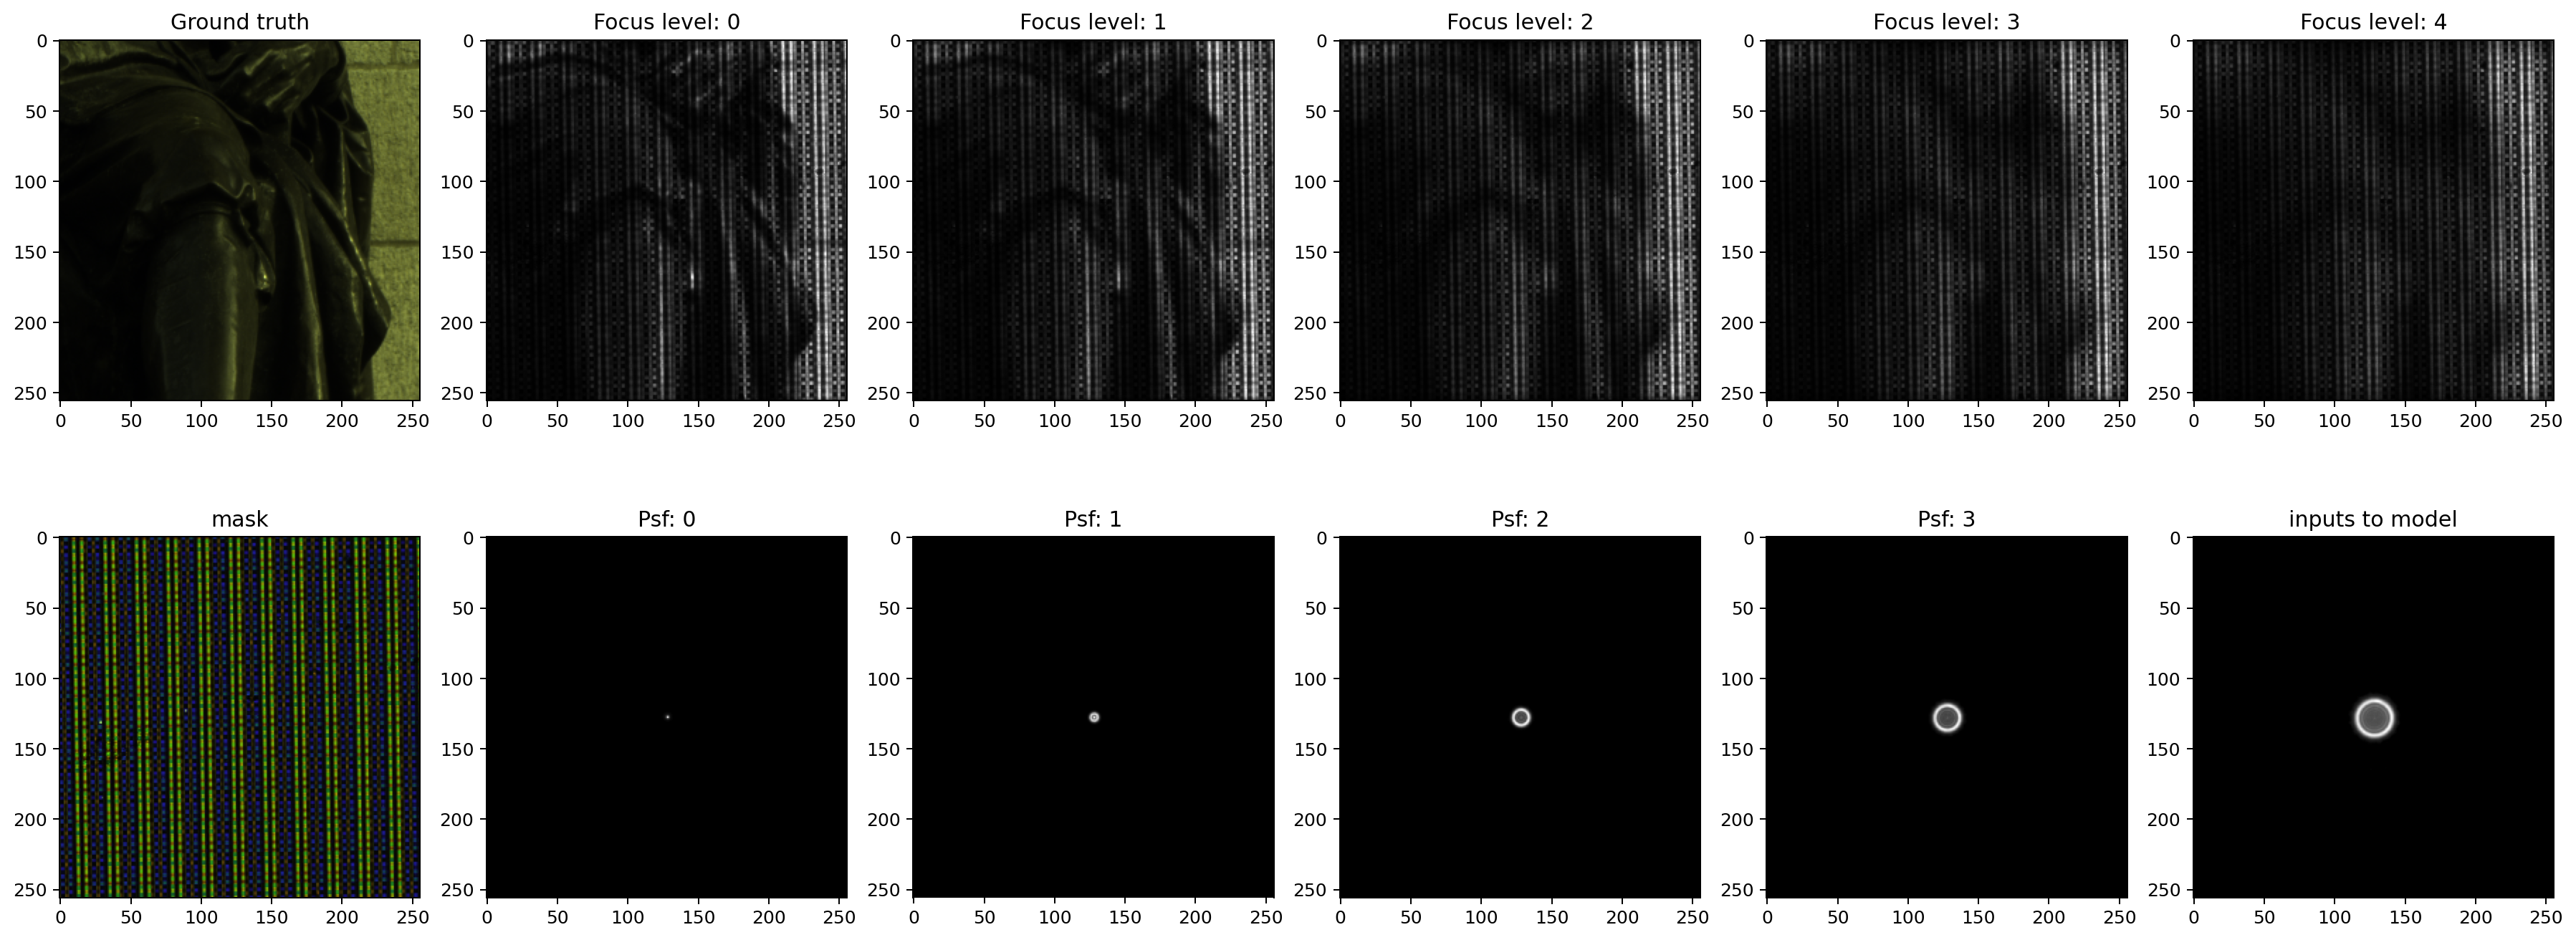

In [8]:
# Let's look at the simulated images and psfs
plot = lambda x: helper.value_norm(helper.stack_rgb_opt_30(np.transpose(x, (1,2,0))))
fig, ax = plt.subplots(2, len(sim_meas_stack)+1, figsize = (4*len(sim_meas_stack), 8))
fig.set_dpi(180)
for i in range(len(sim_meas_stack)+1):
    if i == 0:
        ax[0][i].imshow(plot(test_img[0].cpu().numpy()))
        ax[0][i].set_title(f"Ground truth")
        ax[1][i].imshow(plot(forward_model.mask[0].cpu().numpy()))
        ax[1][i].set_title(f"mask")
    else:
        ax[0][i].imshow(sim_meas_stack[i-1].cpu().numpy(), cmap='gray')
        ax[0][i].set_title(f"Focus level: {i-1}")
        ax[1][i].imshow(forward_model.psfs[i-1].cpu().numpy(), cmap='gray')
        ax[1][i].set_title(f"Psf: {i-1}")
plt.title("inputs to model")
plt.tight_layout()
plt.show()

## Run model with fista recon

iteration:  0  loss:  tensor(1.9407e+08, device='cuda:1', dtype=torch.float64)


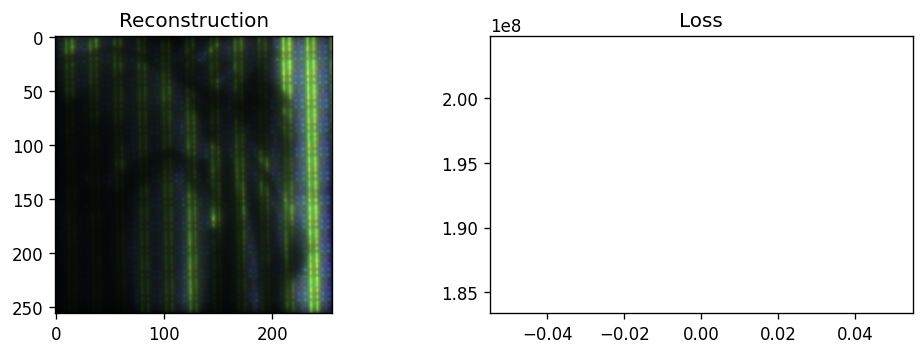

iteration:  100  loss:  tensor(14505.5514, device='cuda:1', dtype=torch.float64)


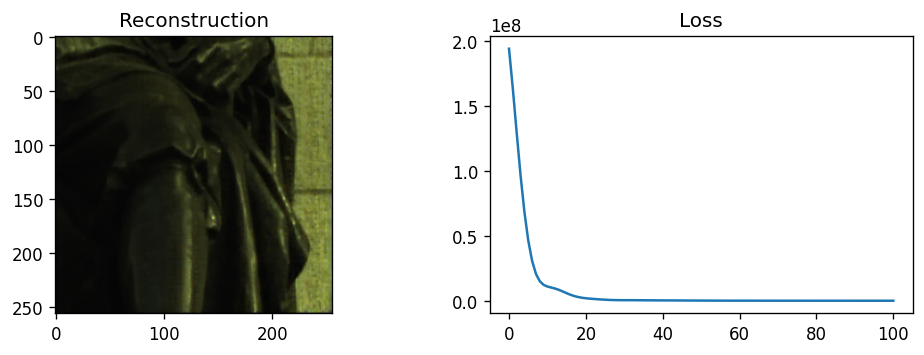

iteration:  200  loss:  tensor(2239.6080, device='cuda:1', dtype=torch.float64)


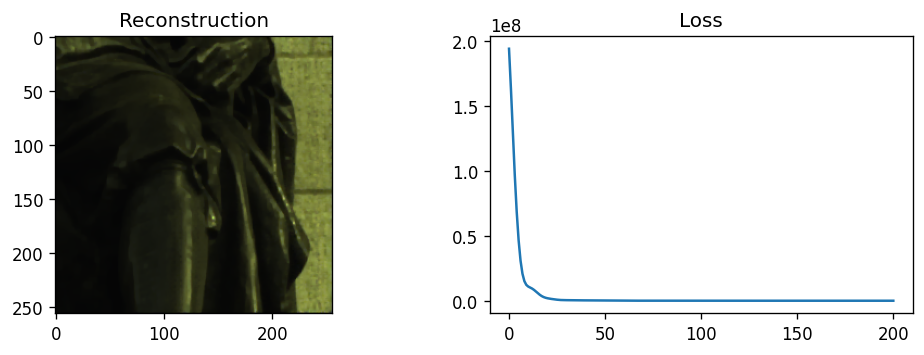

iteration:  300  loss:  tensor(772.2422, device='cuda:1', dtype=torch.float64)


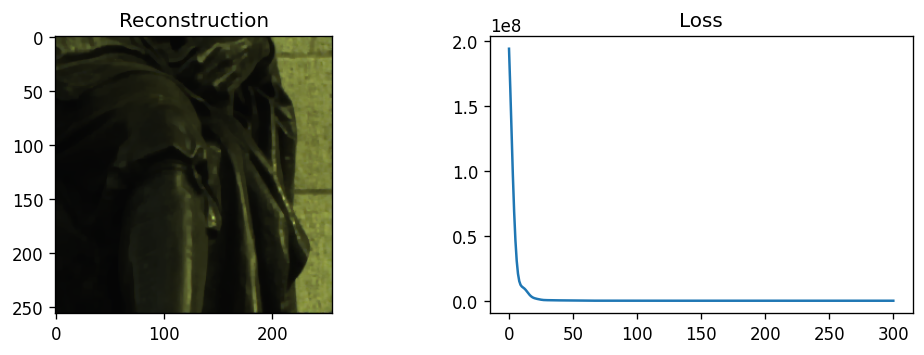

iteration:  400  loss:  tensor(486.4123, device='cuda:1', dtype=torch.float64)


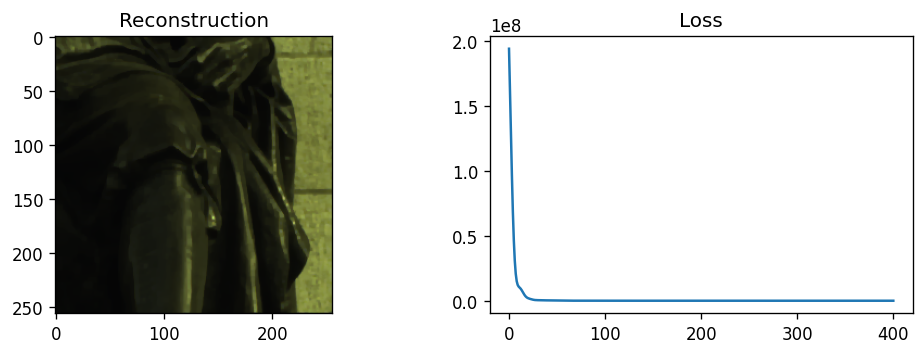

iteration:  500  loss:  tensor(430.6686, device='cuda:1', dtype=torch.float64)


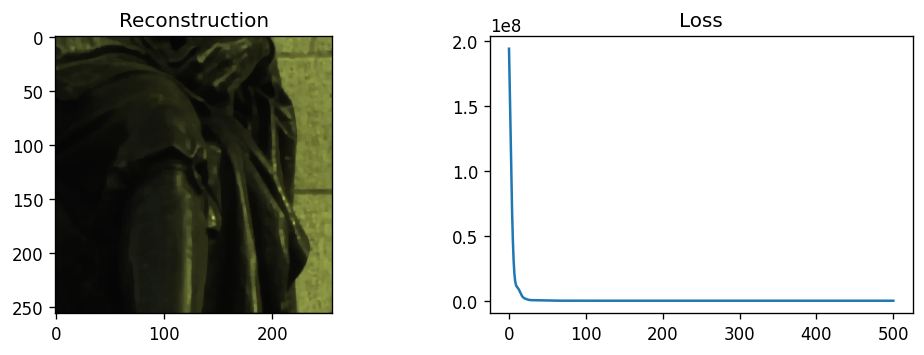

iteration:  600  loss:  tensor(409.8184, device='cuda:1', dtype=torch.float64)


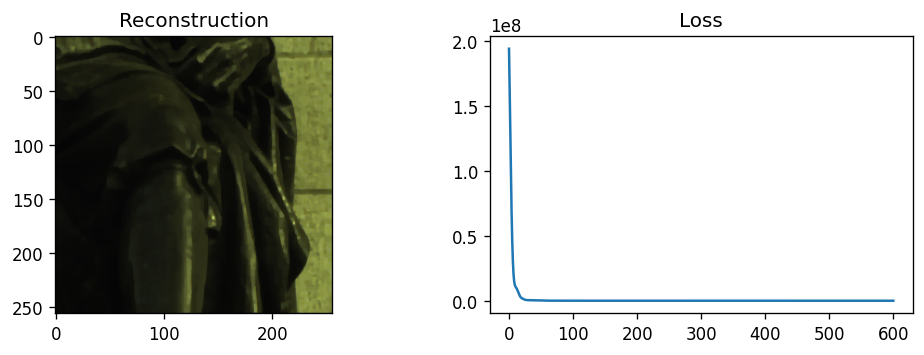

iteration:  700  loss:  tensor(409.8507, device='cuda:1', dtype=torch.float64)


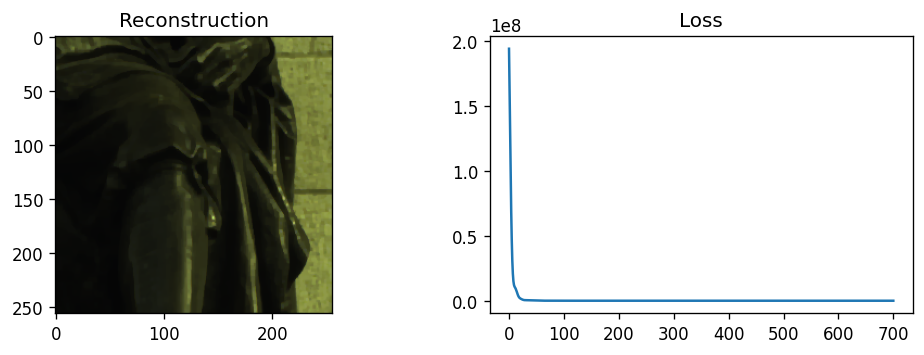

In [7]:
out = model.model2(sim_meas_stack)
recon = model.model2.out_img

### Visualize Outputs

In [8]:
recon = model.model2.out_img
helper.plot_cube_interactive(recon) #click on image to see spectra

FigureWidget({
    'data': [{'type': 'image',
              'uid': '6630881f-dc0a-4bbd-9986-93a9a21d8415',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 39,  44,  14],
                           [ 42,  47,  22],
                           [ 42,  47,  22],
                           ..., 
                           [120, 130,  57],
                           [119, 136,  58],
                           [110, 136,  57]],
                   
                          [[ 46,  50,  17],
                           [ 48,  52,  23],
                           [ 48,  53,  24],
                           ..., 
                           [126, 140,  62],
                           [122, 140,  60],
                           [115, 134,  59]],
                   
                          [[ 48,  52,  21],
                           [ 48,  53,  23],
                           [ 48,  53,  24],
                           ..., 
                           [127, 138

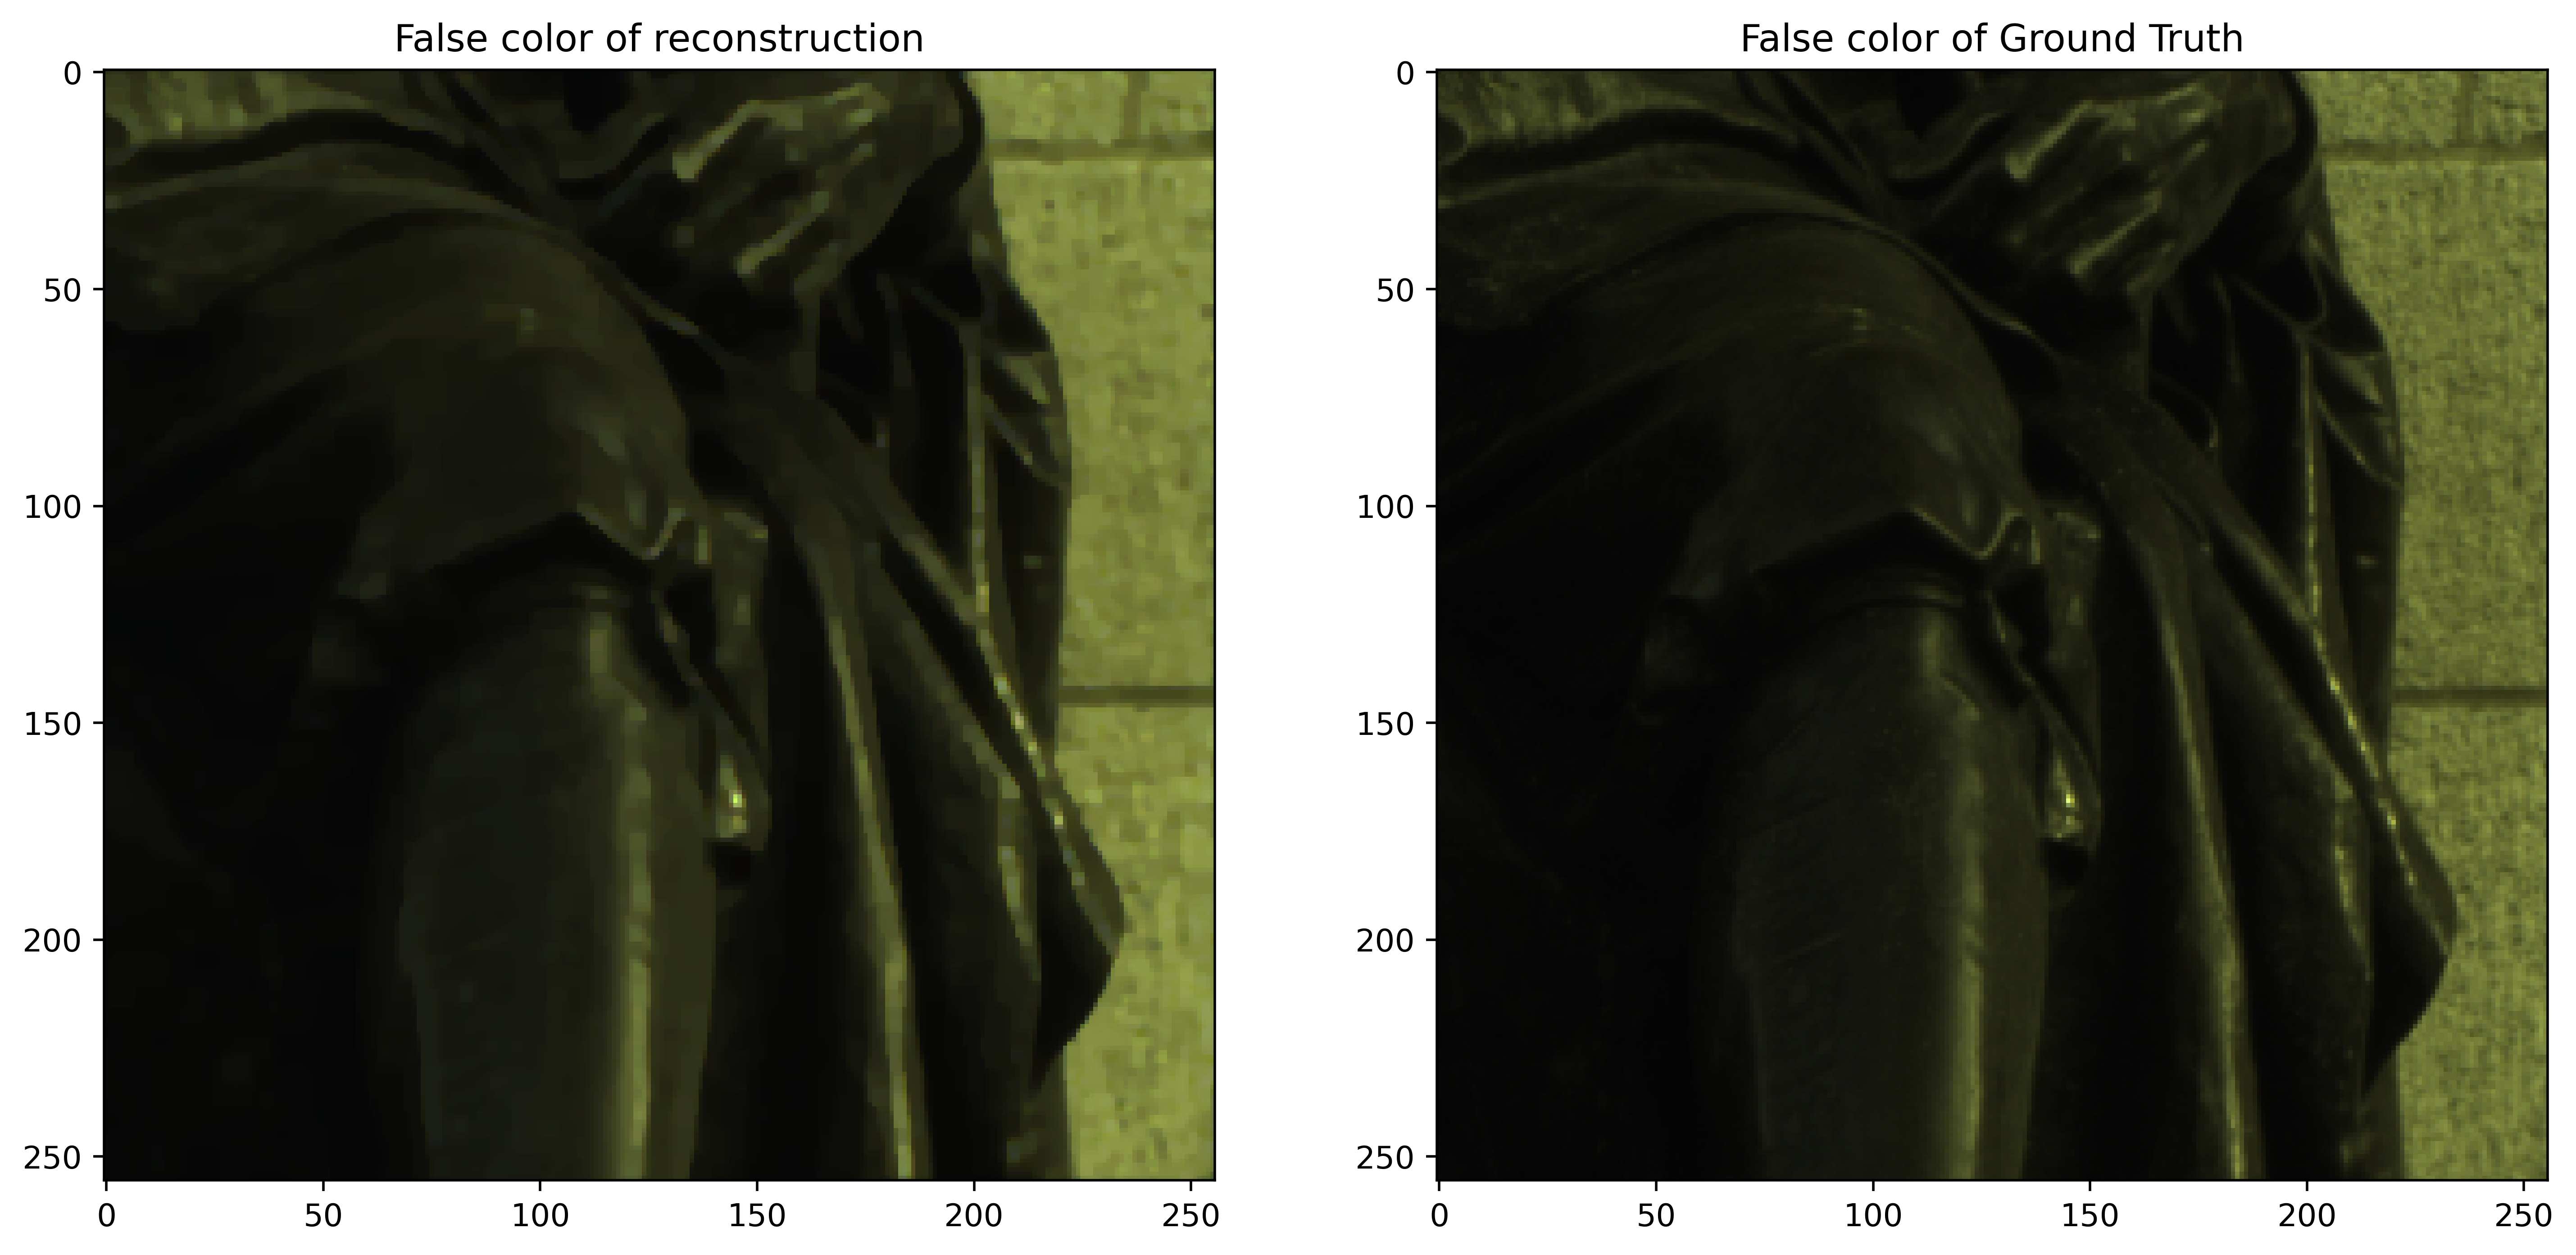

In [11]:
# Visualize in false color
fc_img = helper.pre_plot(helper.stack_rgb_opt_30(recon), False)
gt_img = helper.pre_plot(helper.stack_rgb_opt_30(test_img.numpy()[0].transpose(1,2,0)), False)

fig, ax = plt.subplots(1,2,figsize= (14,7))
ax[0].imshow(fc_img)
ax[0].set_title("False color of reconstruction")
ax[1].imshow(gt_img)
ax[1].set_title("False color of Ground Truth")
plt.show()

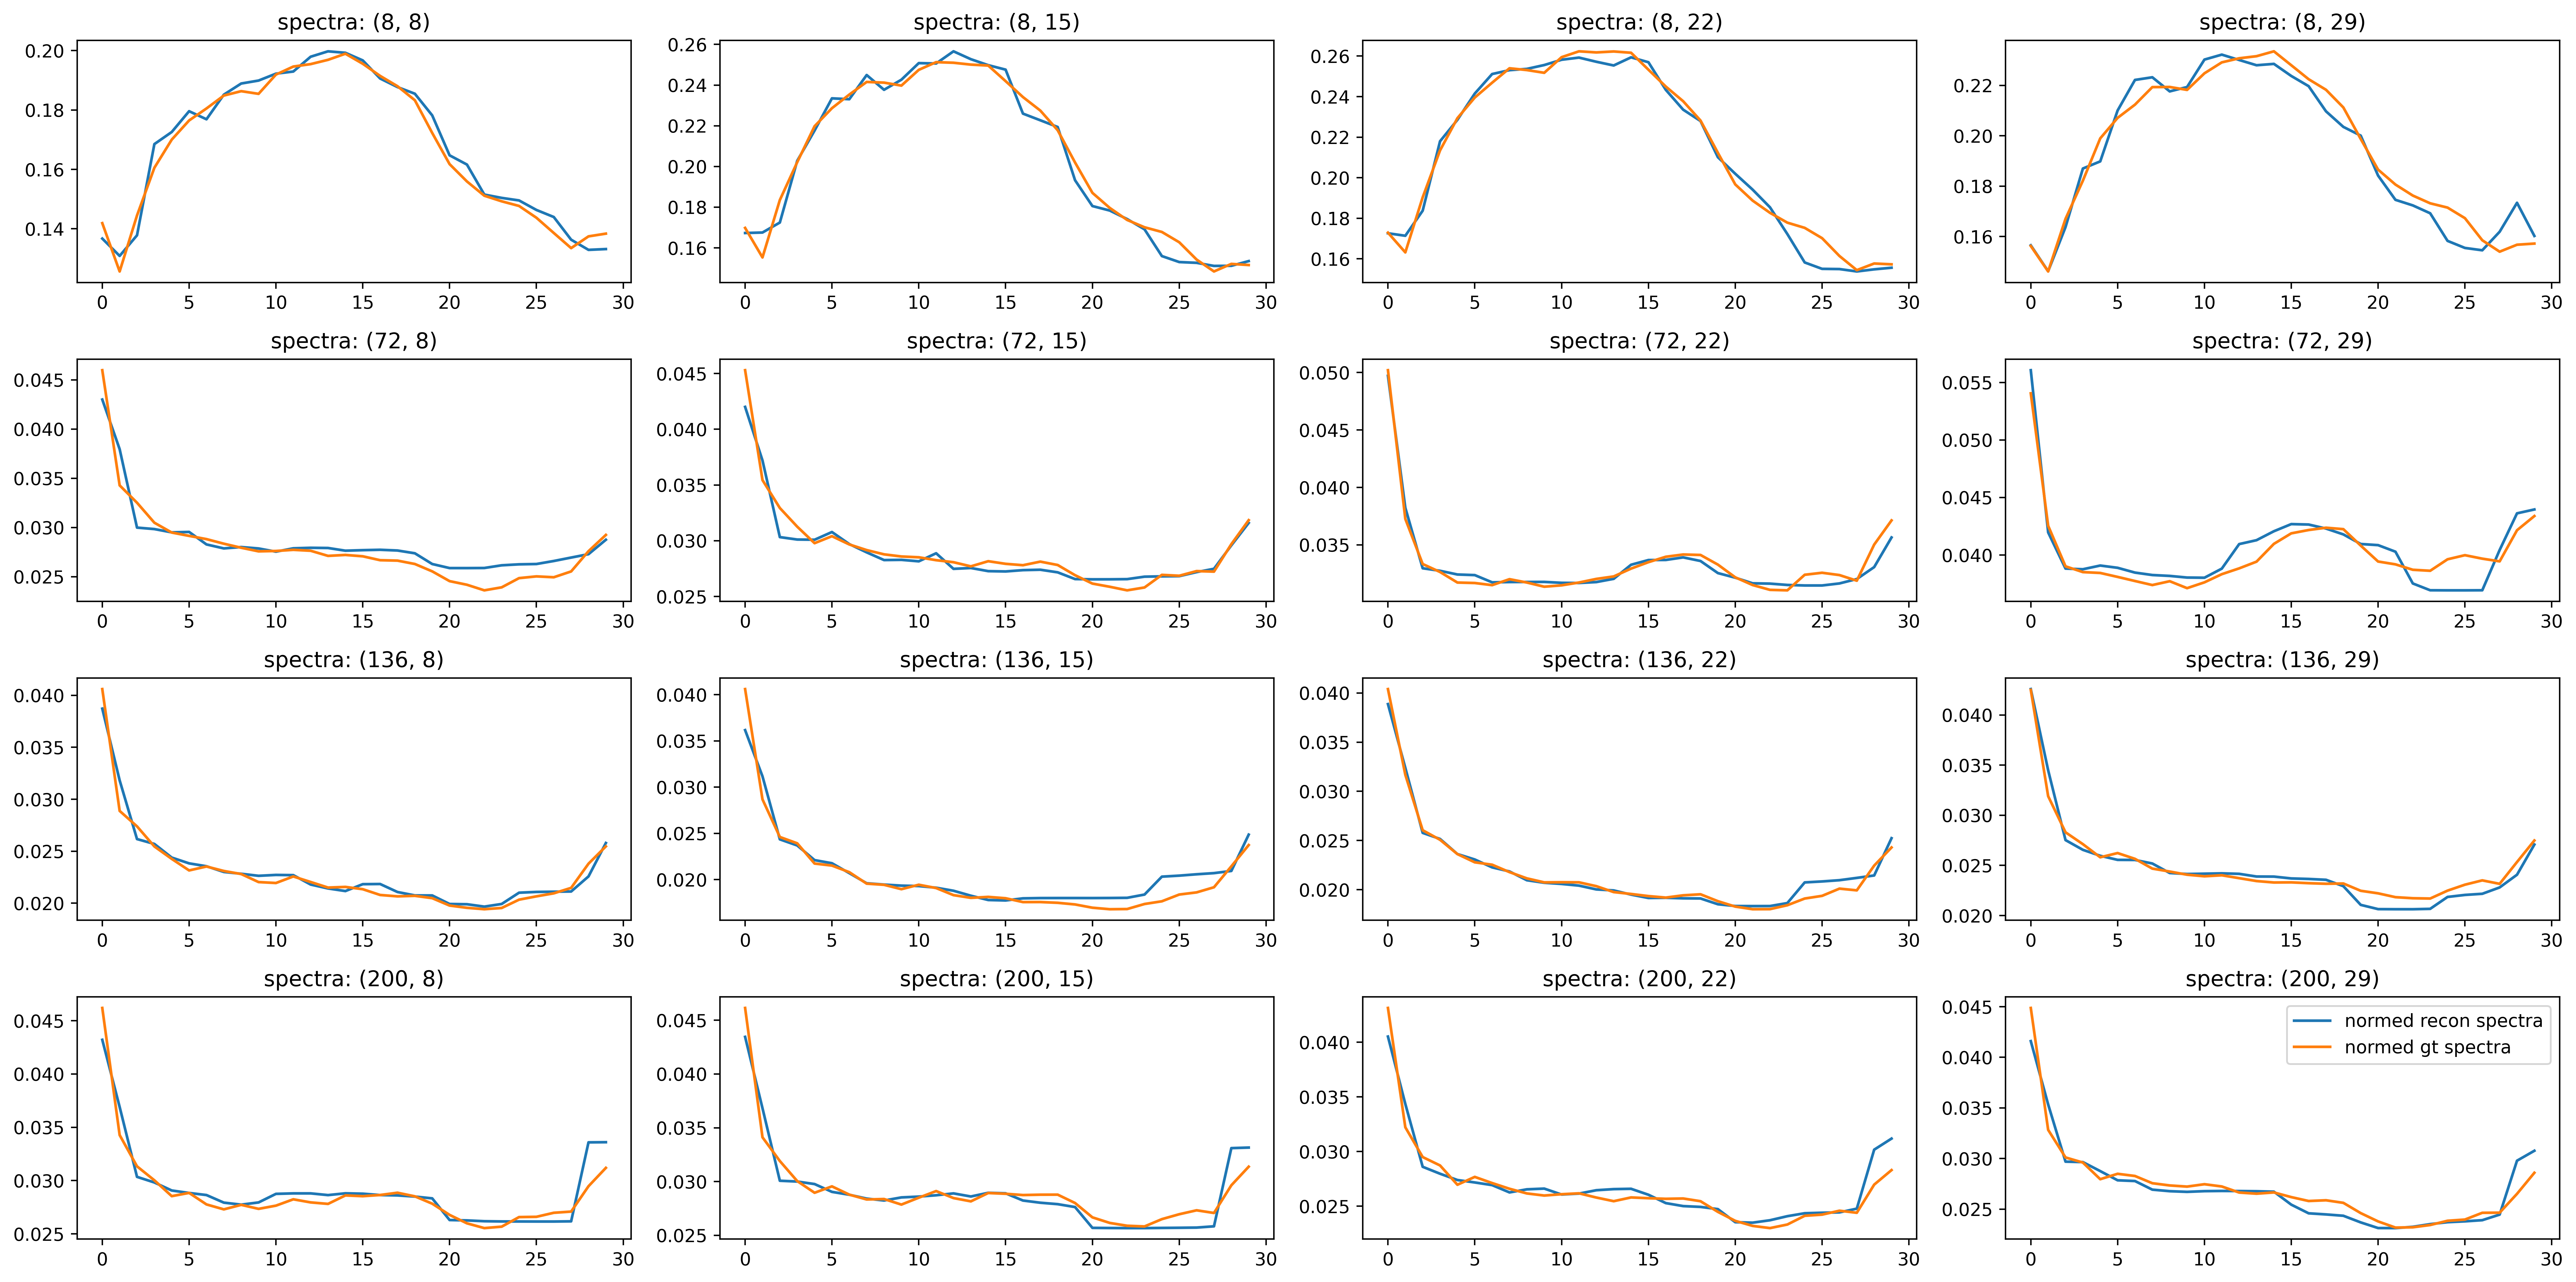

In [19]:
# Visualize spectra
fig, ax = plt.subplots(4,4,figsize=(20,10))
gt = test_img.numpy()[0].transpose(1,2,0)

for i in range(4):
    for j in range(4):
        x = (gt.shape[1] // 4) * i + 8
        y = (gt.shape[2] // 4) * j + 8
        ax[i][j].plot(np.mean(recon[x-4:x+4,y-4:y+4,:],axis=(0,1))/numpy.max(recon)*1.25, label="normed recon spectra")
        ax[i][j].plot(np.mean(gt[x-4:x+4,y-4:y+4,:],axis=(0,1))/numpy.max(gt), label="normed gt spectra")
        ax[i][j].set_title(f"spectra: {x, y}")
plt.legend()
plt.tight_layout()
plt.show()